<a href="https://colab.research.google.com/github/Harshbhatt2409/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/. kaggle

mkdir: cannot create directory ‘/root/.’: File exists
mkdir: cannot create directory ‘kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/. kaggle/kaggle.json

In [ ]:
!kaggle d download grouplens/movielens-20m-dataset

movielens-20m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
replace genome_scores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import math 
import itertools
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.neighbors import NearestNeighbors
from keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [ ]:
rates = pd.read_csv('rating.csv')
rates.drop(['timestamp'],axis=1, inplace=True)
print('table of rates : (rows, features): ', rates.shape)
movies = pd.read_csv('movie.csv')
print('table of movies : (rows, features): ', movies.shape)
rates.head()

table of rates : (rows, features):  (20000263, 3)
table of movies : (rows, features):  (27278, 3)


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
users = rates.userId.unique()
user_map = {i:val for i, val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
Movies = rates.movieId.unique()
movie_map = {i:val for i,val in enumerate(Movies)}
inverse_movie_map = {val:i for i,val in enumerate(Movies)}

print("We have %d users"%users.shape[0])
print("We have %d movies"%Movies.shape[0])

We have 138493 users
We have 26744 movies


In [ ]:
rates.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [ ]:
ratings_df = rates.groupby(['userId','movieId']).aggregate(np.max)
print(len(ratings_df))
if(len(ratings_df) == rates.shape[0]):
  print("there are no such cases where the user has rated the same movie twice")

20000263
there are no such cases where the user has rated the same movie twice


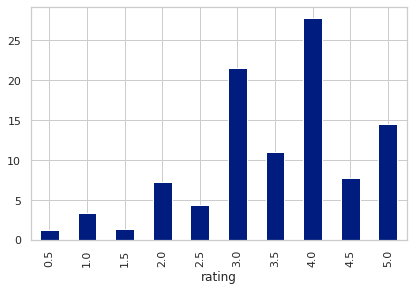

In [ ]:
count_rates = rates.groupby('rating').count()
count_rates['perc_total'] = round(count_rates['userId']*100/count_rates['userId'].sum(),1)
count_rates['perc_total'].plot.bar()

In [ ]:
ratedmovies = pd.merge(rates, movies, on='movieId')
ratedmovies.tail()

,userId,movieId,rating,title,genres
20000258,138301,121017,3.5,The Gentleman from Epsom (1962),Comedy|Crime
20000259,138301,121019,4.5,The Great Spy Chase (1964),Action|Comedy|Thriller
20000260,138301,121021,4.5,Taxi for Tobruk (1961),Drama|War
20000261,138406,110167,4.5,"Judge and the Assassin, The (Juge et l'assassi...",Crime|Drama
20000262,138406,110510,4.5,Série noire (1979),Film-Noir


Genres Distribution

In [ ]:
genres = {}
def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word] = genres.get(word,0)+1
find_genres()
genres['None'] = genres.pop('(no genres listed)')
listofgenres = list(genres.keys())
genres

{'Adventure': 2329,
 'Animation': 1027,
 'Children': 1139,
 'Comedy': 8374,
 'Fantasy': 1412,
 'Romance': 4127,
 'Drama': 13344,
 'Action': 3520,
 'Crime': 2939,
 'Thriller': 4178,
 'Horror': 2611,
 'Mystery': 1514,
 'Sci-Fi': 1743,
 'IMAX': 196,
 'Documentary': 2471,
 'War': 1194,
 'Musical': 1036,
 'Western': 676,
 'Film-Noir': 330,
 'None': 246}

In [ ]:
MoviesWithGenres = movies.copy()
for genre in listofgenres:
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis=1)
MoviesWithGenres.head()  

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,None
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


List of top rated movies

In [ ]:
avg_movie_rating = pd.DataFrame(rates.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId'] = avg_movie_rating.index
avg_rating_all = rates['rating'].mean()
min_reviews = 20
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.index.name = None
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
  v=x['count']
  R=x['mean']
  return (v/(v+m)*R) + (m/(m+v)*C)

movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score = pd.merge(movie_score, MoviesWithGenres, on='movieId')
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,title,count,mean,weighted_score,genres
312,"Shawshank Redemption, The (1994)",63366,4.446990,4.446700,Crime|Drama
826,"Godfather, The (1972)",41355,4.364732,4.364327,Crime|Drama
49,"Usual Suspects, The (1995)",47006,4.334372,4.334028,Crime|Mystery|Thriller
516,Schindler's List (1993),50054,4.310175,4.309862,Drama|War
1168,"Godfather: Part II, The (1974)",27398,4.275641,4.275093,Crime|Drama
1885,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.272892,Action|Adventure|Drama
869,Rear Window (1954),17449,4.271334,4.270480,Mystery|Thriller
6966,Band of Brothers (2001),4305,4.263182,4.259771,Action|Drama|War
877,Casablanca (1942),24349,4.258327,4.257725,Drama|Romance
887,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935,4.254700,Drama|Film-Noir|Romance


Getting top n rated movies per genre

In [ ]:
def best_by_genre(genre,top_n):
  return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

best_by_genre('Drama',5) 

,title,count,mean,weighted_score
312,"Shawshank Redemption, The (1994)",63366,4.446990,4.446700
826,"Godfather, The (1972)",41355,4.364732,4.364327
516,Schindler's List (1993),50054,4.310175,4.309862
1168,"Godfather: Part II, The (1974)",27398,4.275641,4.275093
1885,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180,4.272892


Heavily Rated Movies

In [ ]:
df_n_ratings = pd.DataFrame(ratedmovies.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(ratedmovies.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Pulp Fiction (1994),4.174231,67310
Forrest Gump (1994),4.029000,66172
"Shawshank Redemption, The (1994)",4.446990,63366
"Silence of the Lambs, The (1991)",4.177057,63299
Jurassic Park (1993),3.664741,59715
Star Wars: Episode IV - A New Hope (1977),4.190672,54502
Braveheart (1995),4.042534,53769
Terminator 2: Judgment Day (1991),3.931954,52244
"Matrix, The (1999)",4.187186,51334


<Figure size 576x288 with 0 Axes>

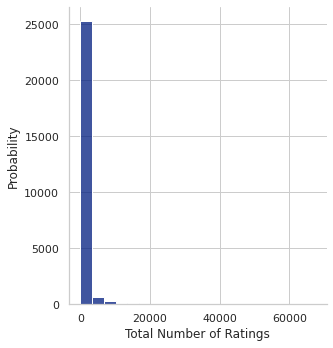

In [ ]:
plt.figure(figsize=(8,4))
sns.displot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


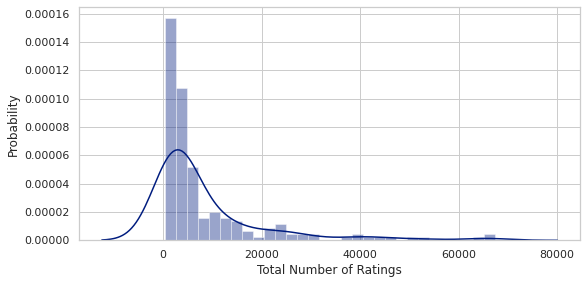

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(best_by_genre('Drama',200)['count'], bins=30)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

Mean rating vs total ratings

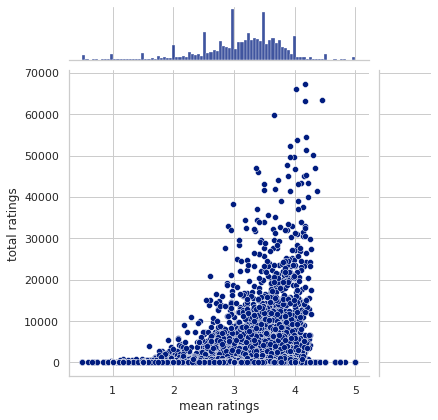

In [ ]:
sns.jointplot(x = 'mean ratings', y='total ratings', data = df_n_ratings)

Content Based Recommendation

In [ ]:
moviesforcontent = movies.copy()
moviesforcontent['genres'] = moviesforcontent['genres'].str.split('|')
moviesforcontent['genres'] = moviesforcontent['genres'].fillna("").astype('str')
moviesforcontent.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(moviesforcontent['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

In [ ]:
def genre_recommendations(title):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse= True)
  sim_scores = sim_scores[1:21]
  movie_indices = [i[0] for i in sim_scores]
  return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Walking Dead, The (1995)').head(10)

72                           Misérables, Les (1995)
212           Before the Rain (Pred dozhdot) (1994)
332                        Walking Dead, The (1995)
523                         Schindler's List (1993)
625     Land and Freedom (Tierra y libertad) (1995)
747                               Stalingrad (1993)
961                         Nothing Personal (1995)
1068                                 Platoon (1986)
1138       Tin Drum, The (Blechtrommel, Die) (1979)
1155                          Paths of Glory (1957)
Name: title, dtype: object

Collaborative Filtering Recommendation Model